In [16]:
import os, math, random, csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageOps
import pandas as pd

In [17]:
SINGLE_IMAGE_PLOT_SCALE = 1.5
FONT_SIZE = 8

DATASET_PATH = '/kaggle/input/rivers-and-lakes'
LABELS_PATH = '/kaggle/input/rivers-and-lakes-classifier-vgg16-based/labels.csv'
WORK_DIRECTORY = '/kaggle/working/'

IMAGE_SIZE_SRC = 64
IMAGE_SIZE = 28

SEED = 2077
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


def show_images(images, cols=10, vmin=-.5, vmax=.5, labels=None, scale=1., font_size=FONT_SIZE):
    cols = min(len(images), cols)
    rows = (len(images) + cols - 1) // cols
    
    fig_scale = SINGLE_IMAGE_PLOT_SCALE * scale
    fig = plt.figure(figsize=(cols*fig_scale, rows*fig_scale))
    
    for i in range(len(images)):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(hspace=.1, wspace=.1, right=.7, top=.7)
        plt.imshow(images[i], cmap='viridis', vmin=vmin, vmax=vmax)
        
        if labels:
            ax.set_title(labels[i], fontsize=font_size, pad=font_size/10)
            plt.subplots_adjust(top=.7+font_size/72)
    
    plt.show()

    
def open_image(path):
    return Image.open(path)

def open_images(paths):
    return [open_image(path) for path in paths]


def show_history(history, names, val_prefix='val_'):
    epochs_count = len(list(history.values())[0])

    fig, ax = plt.subplots(1, len(names), squeeze=False)
    fig.set_figwidth(10)

    for subax, name in zip(ax.ravel(), names):
        subax.plot(range(epochs_count), history[name], label=name)

        if val_prefix + name in history:
            subax.plot(range(epochs_count), history[val_prefix + name], label=val_prefix+name)

        subax.legend()
        subax.grid()
        
        
class GrayscaleLayer(layers.Layer):
    def call(self, inputs):
        return tf.image.rgb_to_grayscale(inputs)

examples of images:


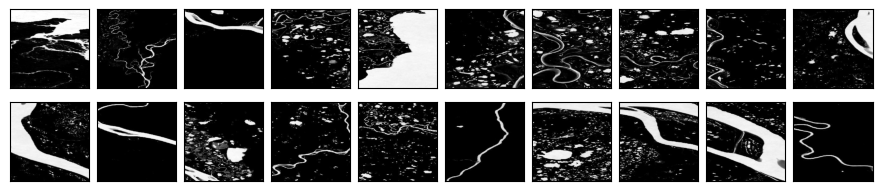

examples of augmentation:


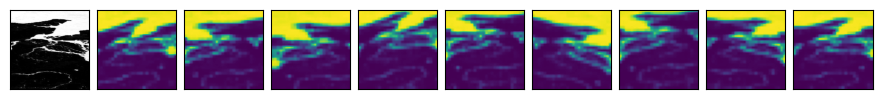

In [18]:
preprocessor = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation((-.08, +.08), (-.08, +.08), interpolation="bilinear"),
    layers.RandomRotation(.04, interpolation="bilinear"),
    layers.RandomZoom((-.05, +.05), interpolation="bilinear"),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, interpolation="bilinear"),
    layers.Rescaling(1/255, offset=-.5),
    GrayscaleLayer(),
])
        
listdir = sorted(os.listdir(DATASET_PATH))

listdir_fullpath = [os.path.join(DATASET_PATH, filename) for filename in listdir]

print('examples of images:')
show_images(open_images(listdir_fullpath[:20]))

print('examples of augmentation:')
show_images([open_image(listdir_fullpath[0])] +
            [preprocessor(open_image(listdir_fullpath[0]).resize((IMAGE_SIZE_SRC, IMAGE_SIZE_SRC))) for i in range(9)])

Found 10000 files belonging to 13 classes.
Using 9900 files for training.
Using 100 files for validation.


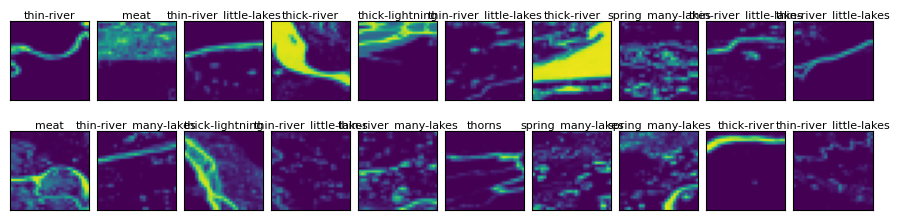

In [19]:
labels = pd.read_csv(LABELS_PATH)

class_names = sorted(labels['class'].unique())

classes = labels['class_int'].to_list()

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_PATH,
    validation_split=0.01,
    labels=classes.copy(),
    label_mode='categorical',
    subset="both",
    batch_size=32,
    image_size=(IMAGE_SIZE_SRC, IMAGE_SIZE_SRC),
    interpolation='area',
    color_mode='rgb',
    seed=SEED,
    shuffle=True)

train_ds = train_ds.map(lambda x, y: (preprocessor(x), y))
val_ds = val_ds.map(lambda x, y: (preprocessor(x), y))

for images_batch, labels_batch in train_ds.take(1):
    labels_batch = [class_names[list(p).index(np.max(p))] for p in labels_batch]
    show_images(images_batch[:20], labels=labels_batch)

0 distortion_jets 243


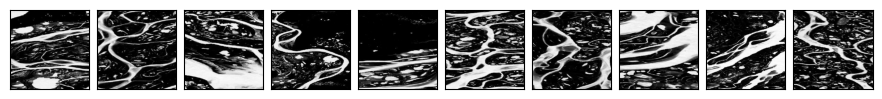

1 meat 482


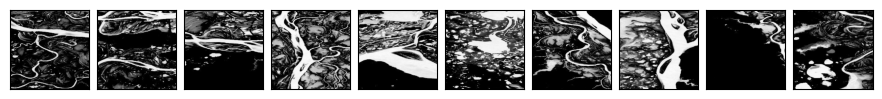

2 overwhelm 50


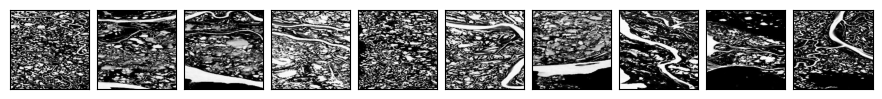

3 shore 576


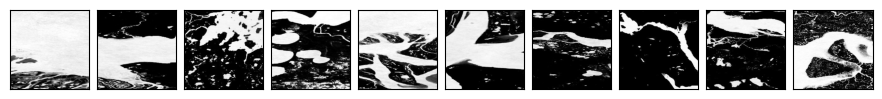

4 spring 1131


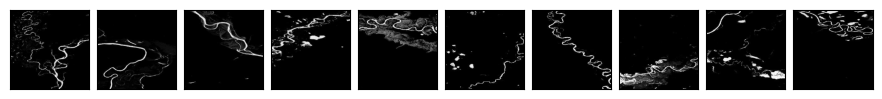

5 spring_many-lakes 1094


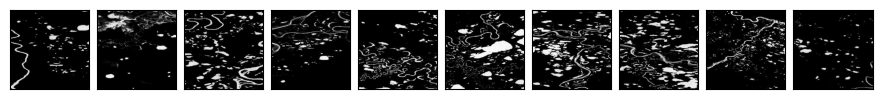

6 thick-lightning 710


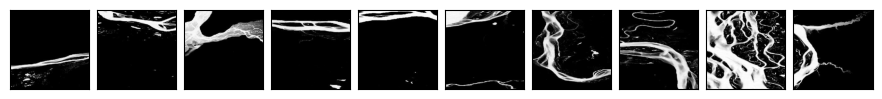

7 thick-river 766


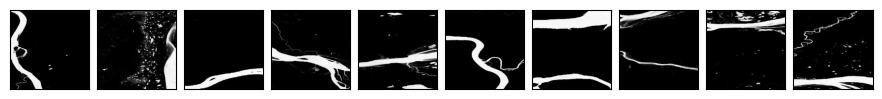

8 thin-lightning 1562


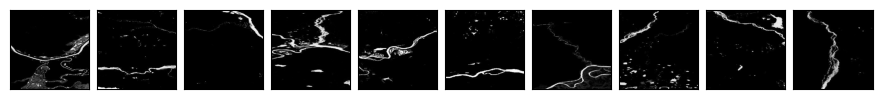

9 thin-river 1002


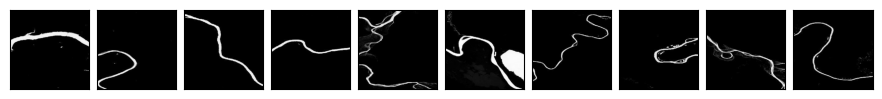

10 thin-river_little-lakes 1060


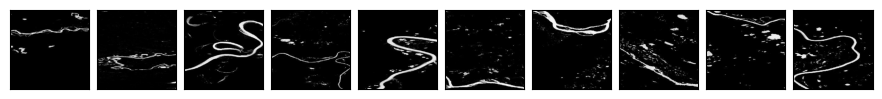

11 thin-river_many-lakes 963


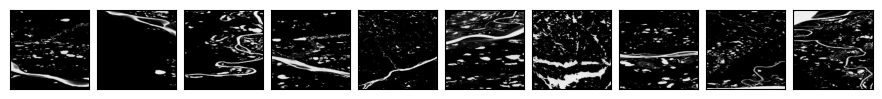

12 thorns 361


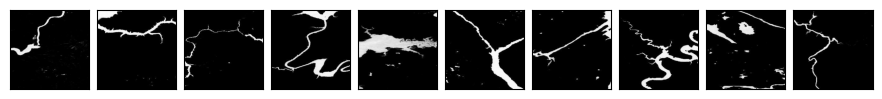

In [20]:
for idx, label in enumerate(class_names):
    indices = [i for i, x in enumerate(classes) if x == idx]
    images = [Image.open(listdir_fullpath[i]) for i in random.sample(indices, min(len(indices), 10))]
    
    print(idx, label, len(indices))
    show_images(images)

In [21]:
latent_dim = 64
num_channels = 1
generator_in_channels = latent_dim + len(class_names)
discriminator_in_channels = num_channels + len(class_names)

def resblock(x, filters, kernelsize):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    return out


d_input = layers.Input(shape=(28, 28, discriminator_in_channels))
x = d_input
x = resblock(x, discriminator_in_channels, 7)
x = layers.Conv2D(32, 7, strides=2, padding="same", activation='relu')(x)
x = resblock(x, 32, 5)
x = layers.Conv2D(64, 5, strides=2, padding="same", activation='relu')(x)
x = resblock(x, 64, 3)
x = layers.Flatten()(x)
x = layers.Dense(1)(x)
discriminator = keras.Model(d_input, x, name='discriminator')
discriminator.summary()

     
g_input = layers.Input(shape=(generator_in_channels,))
x = g_input
x = layers.Dense(7 * 7 * generator_in_channels, activation='relu')(x)
x = layers.Reshape((7, 7, generator_in_channels))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation='relu')(x)
x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation='relu')(x)
x = layers.Conv2DTranspose(32, 5, strides=1, padding="same", activation='relu')(x)
x = layers.Conv2DTranspose(16, 5, strides=1, padding="same", activation='relu')(x)
x = layers.Conv2DTranspose(8, 7, strides=1, padding="same", activation='relu')(x)
x = layers.Conv2D(1, 7, padding="same")(x)
generator = keras.Model(g_input, x, name='generator')
generator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 14)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 14)   9618        ['input_3[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 14)   9618        ['conv2d_9[0][0]']               
                                                                                                  
 add_3 (Add)                    (None, 28, 28, 14)   0           ['input_3[0][0]',    

In [28]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, n_classes):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = tf.repeat(one_hot_labels, repeats=[IMAGE_SIZE * IMAGE_SIZE])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, IMAGE_SIZE, IMAGE_SIZE, self.n_classes))

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
    def call(self, data):
        return self.generator(tf.concat(data, axis=1))
    
    def unite(self, images, ohe):
        image_one_hot_labels = tf.repeat(ohe, repeats=[IMAGE_SIZE * IMAGE_SIZE])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, IMAGE_SIZE, IMAGE_SIZE, self.n_classes))
        real_image_and_labels = tf.concat([images, image_one_hot_labels], -1)
        return real_image_and_labels
    
    def test_step(self, data):
        real_images, one_hot_labels = data
        real_image_and_labels = self.unite(real_images, one_hot_labels)
        predictions = self.discriminator(real_image_and_labels)
        
        batch_size = tf.shape(real_images)[0]
        labels = tf.zeros((batch_size, 1))
        d_loss = self.loss_fn(labels, predictions)
        
        return {"d_loss": d_loss}
        
    
    def generate_gan_noise(self, n):
        return tf.random.normal((n, self.latent_dim), mean=0.0, stddev=1)
    
    def generate_classes_ohe(self, n):
        random_classes = tf.random.uniform(shape=(n,), minval=0, maxval=self.n_classes, dtype=tf.int64)
        return keras.utils.to_categorical(random_classes, num_classes=self.n_classes)
    
    def generate(self, n):
        return self.call([self.generate_gan_noise(n), self.generate_classes_ohe(n)])

    
class ShowReconstructionsCallback(keras.callbacks.Callback):
    def __init__(self, model, n=10, k=1):
        super().__init__()
        self.k = k
        self.gens = []
        noises = model.generate_gan_noise(n)
        classes = model.generate_classes_ohe(n)
        self.inputs = [noises, classes]
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.k == 0:
            self.gens = [*self.gens, *self.model.predict(self.inputs, verbose=0)]

    
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim, n_classes=len(class_names)
)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

recon_cb = ShowReconstructionsCallback(cond_gan, k=10)
history = cond_gan.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=[recon_cb])

Epoch 1/10
310/310 [==============================] - 38s 101ms/step - g_loss: 1.2811 - d_loss: 0.5812 - val_d_loss: 0.6426
Epoch 2/10
310/310 [==============================] - 31s 99ms/step - g_loss: 1.0773 - d_loss: 0.5455 - val_d_loss: 1.3708
Epoch 3/10
310/310 [==============================] - 32s 101ms/step - g_loss: 1.4201 - d_loss: 0.5749 - val_d_loss: 0.7178
Epoch 4/10
310/310 [==============================] - 31s 100ms/step - g_loss: 1.7825 - d_loss: 0.5288 - val_d_loss: 0.0030
Epoch 5/10
310/310 [==============================] - 32s 101ms/step - g_loss: 2.0546 - d_loss: 0.4858 - val_d_loss: 0.5334
Epoch 6/10
310/310 [==============================] - 32s 101ms/step - g_loss: 1.1039 - d_loss: 0.5951 - val_d_loss: 0.2603
Epoch 7/10
310/310 [==============================] - 31s 99ms/step - g_loss: 1.1870 - d_loss: 0.5984 - val_d_loss: 0.6036
Epoch 8/10
310/310 [==============================] - 31s 99ms/step - g_loss: 1.1312 - d_loss: 0.5905 - val_d_loss: 0.9184
Epoch 9/10


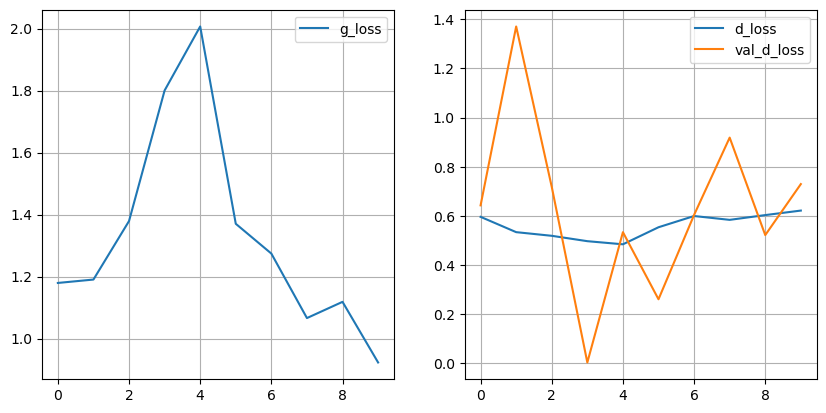

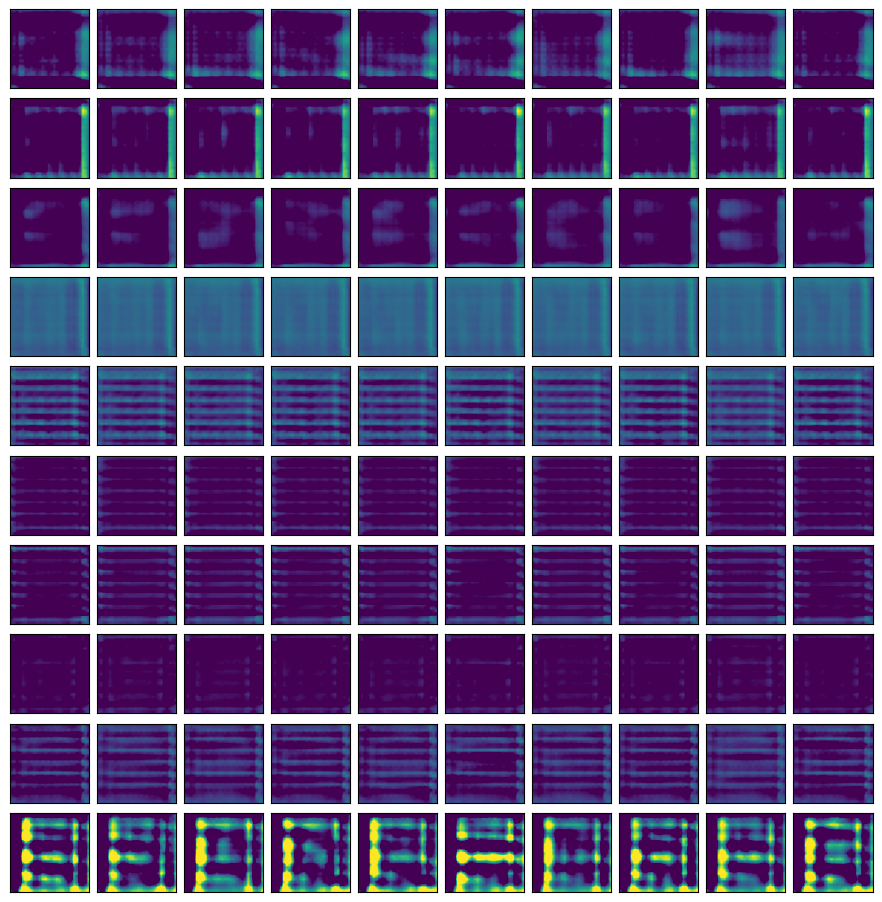

In [29]:
show_history(history.history, ['g_loss', 'd_loss'])
show_images(recon_cb.gens)

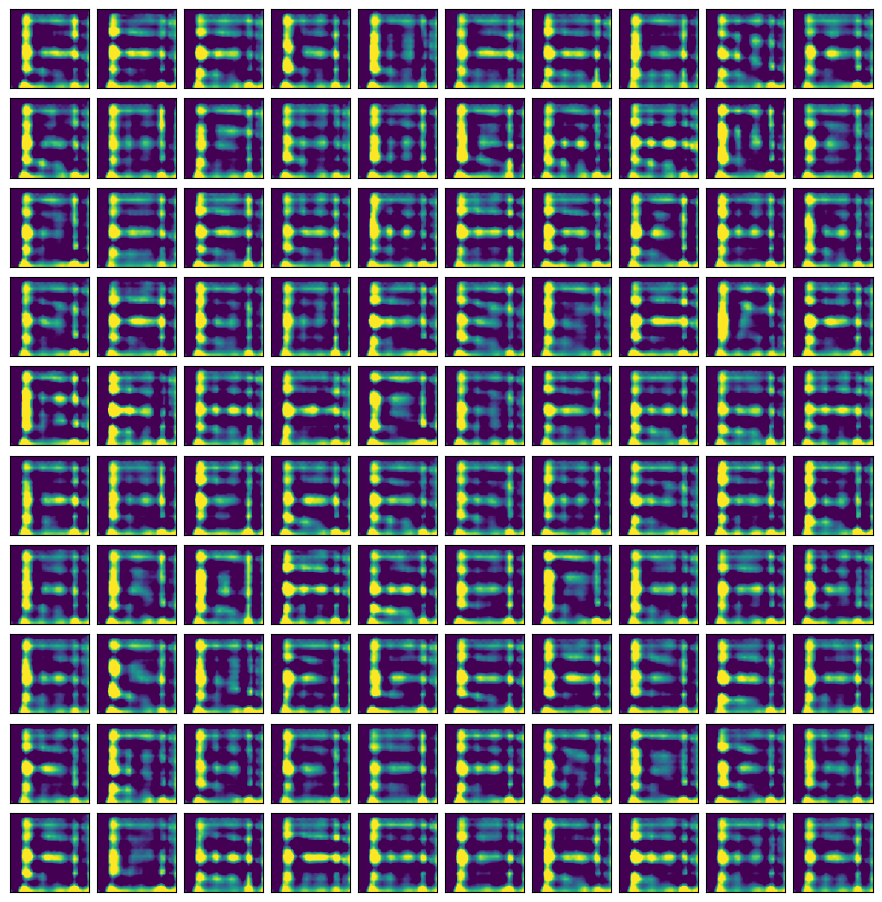

In [30]:
show_images(cond_gan.generate(100))

In [ ]:
cond_gan.generator.save(os.path.join(WORK_DIRECTORY, 'generator.keras'))
cond_gan.discriminator.save(os.path.join(WORK_DIRECTORY, 'discriminator.keras'))

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(cond_gan.generator, './generatorjs')
tfjs.converters.save_keras_model(cond_gan.discriminator, './discriminatorjs')